In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import json
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.models import load_model
from src.custom_loss import weighted_sum_loss
from src.model import mean_teacher
from src.data_generator import mean_teacher_data_gen
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.InteractiveSession(config=config)  

In [4]:
WEIGHTS_PATH = os.path.join(os.getcwd(), 'weights', 'mean_teacher-28-0.12.hdf5')
REDUCED_DATA_PATH = os.path.join(os.getcwd(), 'reduced_data')

In [5]:
with open(os.path.join(os.getcwd(), 'configs', 'model.json')) as f:
    model_configs = json.load(f)
    
with open(os.path.join(os.getcwd(), 'configs', 'training.json')) as f:
    training_configs = json.load(f)

In [6]:
real_data_gen = ImageDataGenerator().flow_from_directory(os.path.join(REDUCED_DATA_PATH, 'real'),
                                                        target_size=training_configs['target_size'], seed = 99)
syn_data_gen = ImageDataGenerator().flow_from_directory(os.path.join(REDUCED_DATA_PATH, 'synthetic'),
                                                     target_size=training_configs['target_size'])

Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [7]:
data_gen = mean_teacher_data_gen(ImageDataGenerator(), ImageDataGenerator(), training_configs['batch_size'], training_configs['target_size'], train_or_val='val')

In [8]:
mean_teacher_model, student_model, teacher_model = mean_teacher(model_configs)

Instructions for updating:
Colocations handled automatically by placer.


/home/dh/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
mean_teacher_model.load_weights(WEIGHTS_PATH)

In [10]:
steps_needed = real_data_gen.n//real_data_gen.batch_size + 1
real_data_gen.reset()
pred = mean_teacher_model.predict_generator(data_gen, steps = steps_needed, verbose = 1)


Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
94/94 [==============================] - 16s 167ms/step


In [11]:
predicted_class_indices=np.argmax(pred,axis=1)

In [12]:
labels = (real_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
class_labels = list(labels.values())
predictions = [labels[k] for k in predicted_class_indices]

In [13]:
data_gen = mean_teacher_data_gen(ImageDataGenerator(), ImageDataGenerator(), training_configs['batch_size'], training_configs['target_size'], train_or_val='val')
mean_teacher_model.evaluate_generator(data_gen, steps = steps_needed, verbose = 1)


Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
94/94 [==============================] - 39s 410ms/step


[28.427027297973634, 0.33633333349227906]

In [14]:
data_gen = mean_teacher_data_gen(ImageDataGenerator(), ImageDataGenerator(), real_data_gen.n, training_configs['target_size'], train_or_val='train')
x, y = next(data_gen)
del x

Y_test = [labels[k] for k in np.argmax(y, axis =1)]
del y

Training mode: source domain is synthetic, target domain is real
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


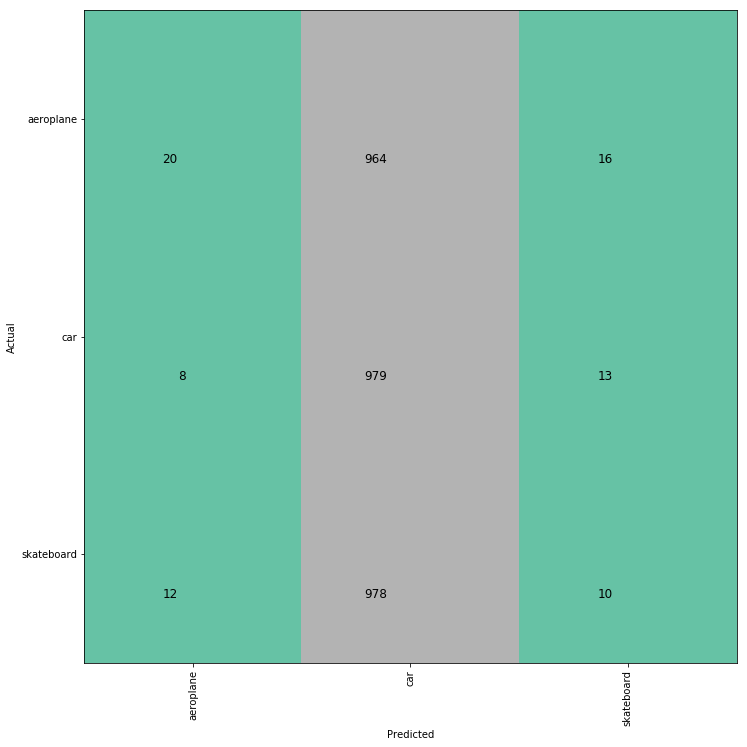

In [15]:
confusion = confusion_matrix(Y_test, predictions, class_labels)
NUM_LABELS = real_data_gen.n
f, axes = plt.subplots(1,1, figsize = (12,12))
axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')
axes.grid(False)
axes.set_xticklabels(class_labels, rotation = 90)
axes.set_yticklabels(class_labels)
axes.set_yticks(list(range(NUM_LABELS)))
axes.set_xticks(list(range(NUM_LABELS)))
plt.imshow(confusion, cmap=plt.cm.Set2, interpolation='nearest')

for i, cas in enumerate(confusion):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=12, color='black')

In [16]:
data_gen = mean_teacher_data_gen(ImageDataGenerator(), ImageDataGenerator(), 8, training_configs['target_size'], train_or_val='val')

In [17]:
%matplotlib notebook


Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


<IPython.core.display.Javascript object>


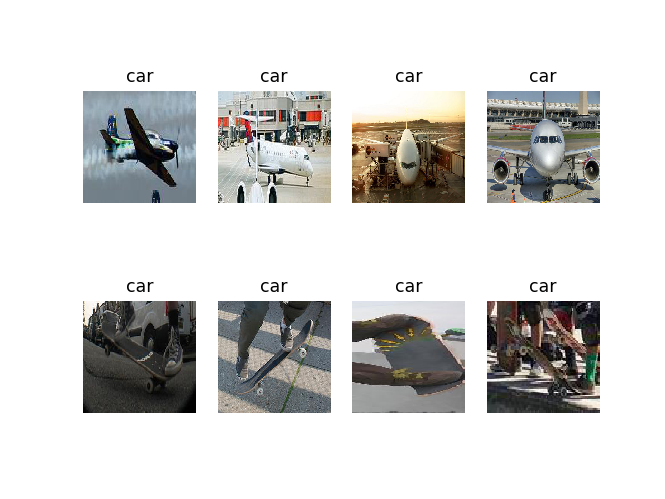

In [18]:
x,y = next(data_gen)
pred = mean_teacher_model.predict(x)
predicted_class_indices=np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
n_rows = 2
n_cols = 4
fig, ax = plt.subplots(n_rows,n_cols)

col_idx = 0
for i, img in enumerate(x[0]):
    row_idx = (i)//n_cols
    ax[row_idx, col_idx].set_axis_off()
    ax[row_idx, col_idx].imshow(img.astype(np.uint8))
    ax[row_idx, col_idx].set_title(predictions[i])
    col_idx += 1
    if col_idx == n_cols:
        col_idx = 0
plt.show()